### Baltimore City Police Emergency and Non-Emergency calls to 911, 2015-2017
Source: https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
from string import punctuation
from datetime import datetime

%matplotlib inline

In [2]:
calls = pd.read_csv('Baltimore_911_Police_Calls_2015-2017.csv')
calls.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,169031,3/3/2015 4:11,High,WD,AUTO ACC/INJURY,P150621008,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n"
1,169032,3/3/2015 4:12,High,WD,AUTO ACC/INJURY,P150621013,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n"
2,169036,3/3/2015 4:16,Low,WD,AUTO ACCIDENT,P150621019,EDMONDSON AV/N PAYSON ST,"N EDMONDSON AV\nBALTIMORE, MD\n"
3,169050,3/3/2015 4:39,Medium,CD,911/NO VOICE,P150621036,1400 MCCULLOH ST,"1400 MCCULLOH ST\nBALTIMORE, MD\n(39.30345, -7..."
4,169057,3/3/2015 4:49,Medium,ED,NARCOTICS INSIDE,P150621049,N ROSE ST/E MONUMENT ST,"N E ROSE ST\nBALTIMORE, MD\n"


### Creating New features

In [3]:
"""Extracts call date, hour, and day from callDateTime"""
calls['timeStamp'] = pd.to_datetime(calls['callDateTime'])
calls['callDate'] = calls['timeStamp'].dt.date
calls['Hour'] = calls['timeStamp'].apply(lambda x: x.hour)
calls['Day'] = calls['timeStamp'].dt.strftime('%A')
calls.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location,timeStamp,callDate,Hour,Day
0,169031,3/3/2015 4:11,High,WD,AUTO ACC/INJURY,P150621008,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:11:00,2015-03-03,4,Tuesday
1,169032,3/3/2015 4:12,High,WD,AUTO ACC/INJURY,P150621013,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:12:00,2015-03-03,4,Tuesday
2,169036,3/3/2015 4:16,Low,WD,AUTO ACCIDENT,P150621019,EDMONDSON AV/N PAYSON ST,"N EDMONDSON AV\nBALTIMORE, MD\n",2015-03-03 04:16:00,2015-03-03,4,Tuesday
3,169050,3/3/2015 4:39,Medium,CD,911/NO VOICE,P150621036,1400 MCCULLOH ST,"1400 MCCULLOH ST\nBALTIMORE, MD\n(39.30345, -7...",2015-03-03 04:39:00,2015-03-03,4,Tuesday
4,169057,3/3/2015 4:49,Medium,ED,NARCOTICS INSIDE,P150621049,N ROSE ST/E MONUMENT ST,"N E ROSE ST\nBALTIMORE, MD\n",2015-03-03 04:49:00,2015-03-03,4,Tuesday


In [4]:
def lat_long(loc):
    """Extracts longitude and latitude from the locations column"""
    lat = None
    long = None
    
    if loc:
        try:
            loc = re.search('\(([^)]+)', loc).group(1)
            loc = re.findall(r"[-+]?\d*\.\d+|\d+", loc)
            lat = loc[0]
            long = loc[1] 
        except:
            pass 
    else:
        return 
    return pd.Series([lat, long], index=['lat', 'long'])

calls[['lat', 'long']] = calls['location'][:].apply(lat_long)

calls.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location,timeStamp,callDate,Hour,Day,lat,long
0,169031,3/3/2015 4:11,High,WD,AUTO ACC/INJURY,P150621008,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:11:00,2015-03-03,4,Tuesday,None,None
1,169032,3/3/2015 4:12,High,WD,AUTO ACC/INJURY,P150621013,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:12:00,2015-03-03,4,Tuesday,None,None
2,169036,3/3/2015 4:16,Low,WD,AUTO ACCIDENT,P150621019,EDMONDSON AV/N PAYSON ST,"N EDMONDSON AV\nBALTIMORE, MD\n",2015-03-03 04:16:00,2015-03-03,4,Tuesday,None,None
3,169050,3/3/2015 4:39,Medium,CD,911/NO VOICE,P150621036,1400 MCCULLOH ST,"1400 MCCULLOH ST\nBALTIMORE, MD\n(39.30345, -7...",2015-03-03 04:39:00,2015-03-03,4,Tuesday,39.30345,-76.628919
4,169057,3/3/2015 4:49,Medium,ED,NARCOTICS INSIDE,P150621049,N ROSE ST/E MONUMENT ST,"N E ROSE ST\nBALTIMORE, MD\n",2015-03-03 04:49:00,2015-03-03,4,Tuesday,None,None


In [5]:
def location_split(loc):
    """Extracts street address, city, and state of the call location"""
    address = None
    city = None
    state = None
    if loc:
        try:
            locSplit = loc.split('\n')
            address = locSplit[0]
            city = locSplit[1].split(',')[0]
            state = locSplit[1].split(',')[1].lstrip().rstrip()
        except:
            pass
    else:
        return
    return pd.Series([address, city, state], index=['address', 'city', 'state'])

calls[['address', 'city', 'state']] = calls['location'][:].apply(location_split)

calls.head()

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location,timeStamp,callDate,Hour,Day,lat,long,address,city,state
0,169031,3/3/2015 4:11,High,WD,AUTO ACC/INJURY,P150621008,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:11:00,2015-03-03,4,Tuesday,None,None,N PAYSON ST,BALTIMORE,MD
1,169032,3/3/2015 4:12,High,WD,AUTO ACC/INJURY,P150621013,N PAYSON ST/EDMONDSON AV,"N PAYSON ST\nBALTIMORE, MD\n",2015-03-03 04:12:00,2015-03-03,4,Tuesday,None,None,N PAYSON ST,BALTIMORE,MD
2,169036,3/3/2015 4:16,Low,WD,AUTO ACCIDENT,P150621019,EDMONDSON AV/N PAYSON ST,"N EDMONDSON AV\nBALTIMORE, MD\n",2015-03-03 04:16:00,2015-03-03,4,Tuesday,None,None,N EDMONDSON AV,BALTIMORE,MD
3,169050,3/3/2015 4:39,Medium,CD,911/NO VOICE,P150621036,1400 MCCULLOH ST,"1400 MCCULLOH ST\nBALTIMORE, MD\n(39.30345, -7...",2015-03-03 04:39:00,2015-03-03,4,Tuesday,39.30345,-76.628919,1400 MCCULLOH ST,BALTIMORE,MD
4,169057,3/3/2015 4:49,Medium,ED,NARCOTICS INSIDE,P150621049,N ROSE ST/E MONUMENT ST,"N E ROSE ST\nBALTIMORE, MD\n",2015-03-03 04:49:00,2015-03-03,4,Tuesday,None,None,N E ROSE ST,BALTIMORE,MD


In [6]:
calls.to_csv('Baltimore_911_updatd.csv', encoding='utf-8')

### Data Visualization

Text(0.5,1,'Baltimore 911 Calls for Service, 2015-2017')

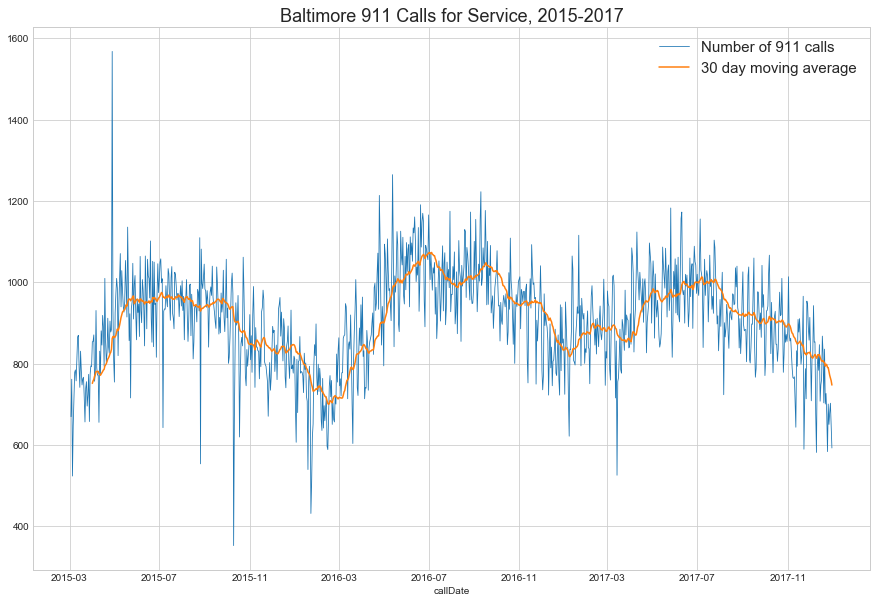

In [306]:
call_count = calls.groupby('callDate').count()['recordId']
call_count.plot(figsize=(15,10), label = 'Number of 911 calls', linewidth=0.8)
call_count.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average')
plt.legend(prop={'size': 15})
plt.title('Baltimore 911 Calls for Service, 2015-2017', fontsize=18)

There is a spike in 911 calls around April/May of 2015. If we zoom into this part of the graph by limiting the x-axis to just 2015 calls, we see that this happens on April 27th, 2015. This was the date of Freddie Gray's funeral, which was followed by a sharp increase in civil disorder in Baltimore.

Text(0.5,1,'Baltimore 911 Calls for Service, 2015')

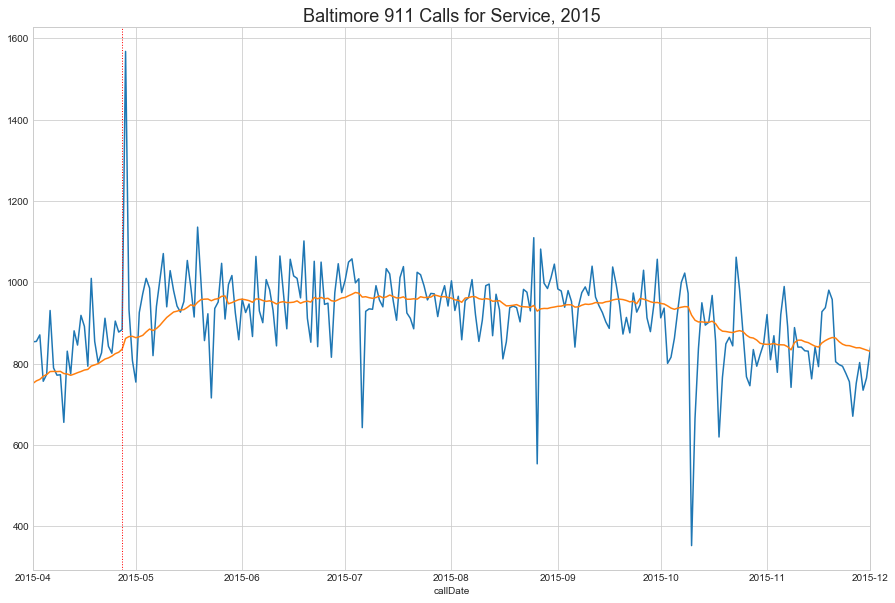

In [308]:
startdate = datetime.strptime('2015-04-01', "%Y-%m-%d").date()
enddate = datetime.strptime('2015-12-01', "%Y-%m-%d").date()
#calls_2015 = calls[(calls['callDate'] > startdate) & (calls['callDate'] < enddate)]

calls.groupby('callDate').count()['recordId'].plot(figsize=(15,10))
calls.groupby('callDate').count()['recordId'].rolling(window=30).mean().plot(figsize=(15,10))

plt.xlim([startdate,enddate])

plt.axvline('2015-04-27', color='r', linestyle=':', linewidth=1)
plt.title('Baltimore 911 Calls for Service, 2015', fontsize=18)

Here are the top 5 most common reasons for 911 call service. We will disregard the top reason '911/NO VOICE', since we are only interested in categorized reasons for the call.

In [303]:
calls['description'].value_counts(ascending=False).head(5)

911/NO  VOICE       178975
DISORDERLY          102823
AUTO ACCIDENT        53843
COMMON ASSAULT       51229
NARCOTICSOutside     43501
Name: description, dtype: int64

Disorderly Calls make up for the majority of reasons for calling, followed by auto accident and common assault.

Text(0.5,1,'Top 3 Most Common 911 Call Descriptions')

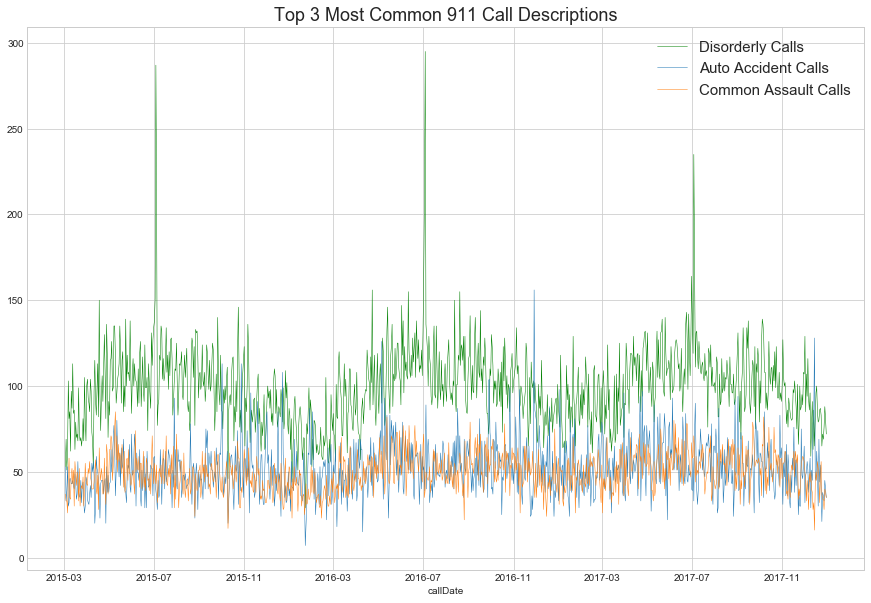

In [305]:
call_disorderly = calls[calls['description'] == 'DISORDERLY'].groupby('callDate').count()['recordId']
call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5, color='g')

call_autoAccident = calls[calls['description'] == 'AUTO ACCIDENT'].groupby('callDate').count()['recordId']
call_autoAccident.plot(figsize=(15,10), label = 'Auto Accident Calls', linewidth=0.5)

call_assault = calls[calls['description'] == 'COMMON ASSAULT'].groupby('callDate').count()['recordId']
call_assault.plot(figsize=(15,10), label = 'Common Assault Calls', linewidth=0.5)

plt.legend(prop={'size': 15})
plt.title('Top 3 Most Common 911 Call Descriptions', fontsize=18)

Calls for disorderly conduct sharply increases every July 4th

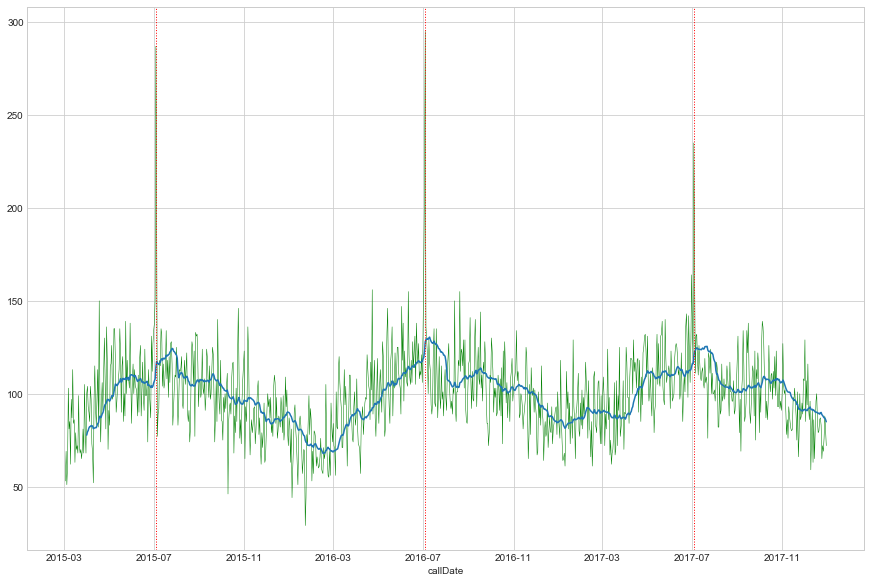

In [312]:
call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5, color='g')
call_disorderly.rolling(window=30).mean().plot(figsize=(15,10))
def july_4th(date):
    plt.axvline(date, color='r', linestyle=':', linewidth=1)
july_4th('2015-07-04')
july_4th('2016-07-04')
july_4th('2017-07-04')

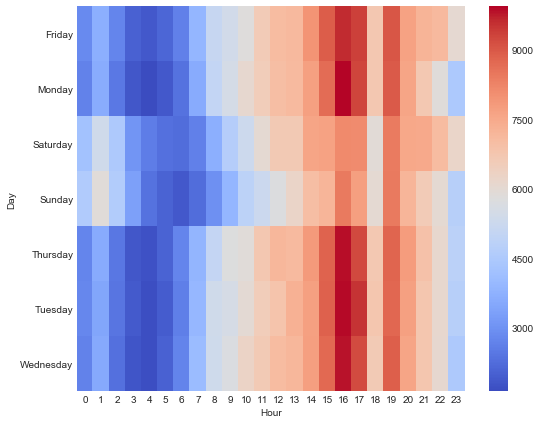

In [231]:
calls_dayHour = calls.groupby(by=['Day', 'Hour']).count()['recordId'].unstack()
calls_dayHour

plt.figure(figsize=(8,6))
sns.heatmap(calls_dayHour, cmap='coolwarm')
plt.tight_layout()

In [6]:
import folium
from folium import plugins

baltLatLong = [39.299236, -76.609383]
baltMap = folium.Map(baltLatLong, zoom_start=12)

# convert lat and long from calls in a list-in-list format for heatmap
calls_latLong_list = calls[['lat', 'long']].dropna()[:50000].values.tolist()

# plot heatmap
baltMap.add_child(plugins.HeatMap(calls_latLong_list, radius=10))
baltMap